In [1]:
from track_generate import FSTrackGenerator
import pandas as pd
import Yaw_optimizer
%matplotlib widget

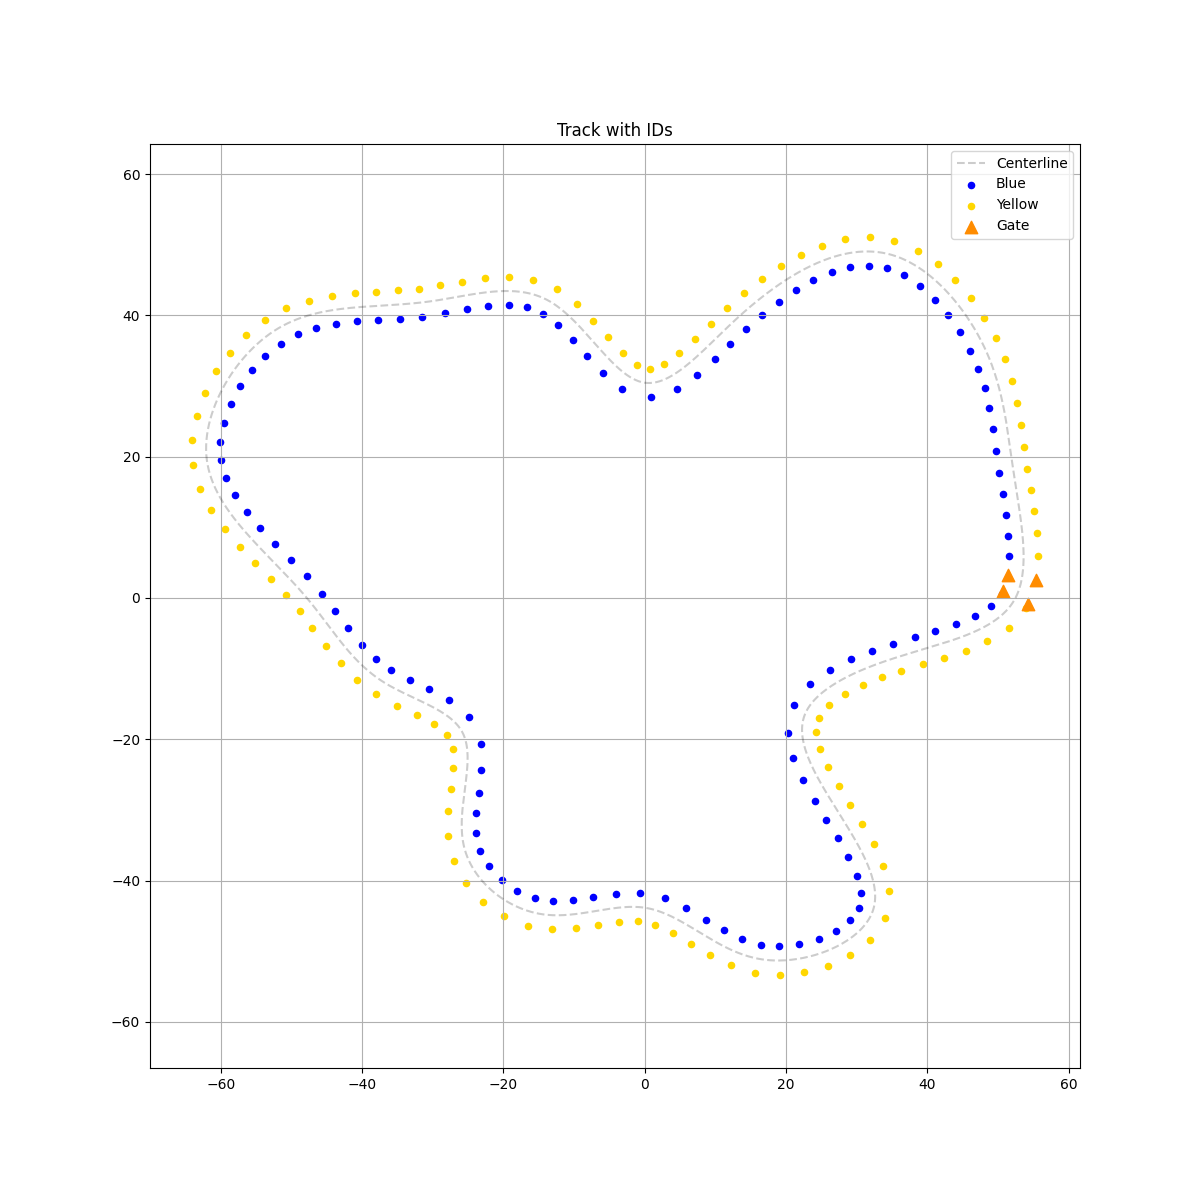

In [2]:
map = FSTrackGenerator()
df = pd.read_csv('tracks/fs_track_7.csv')
map.load_from_dataframe(df)
map.plot()

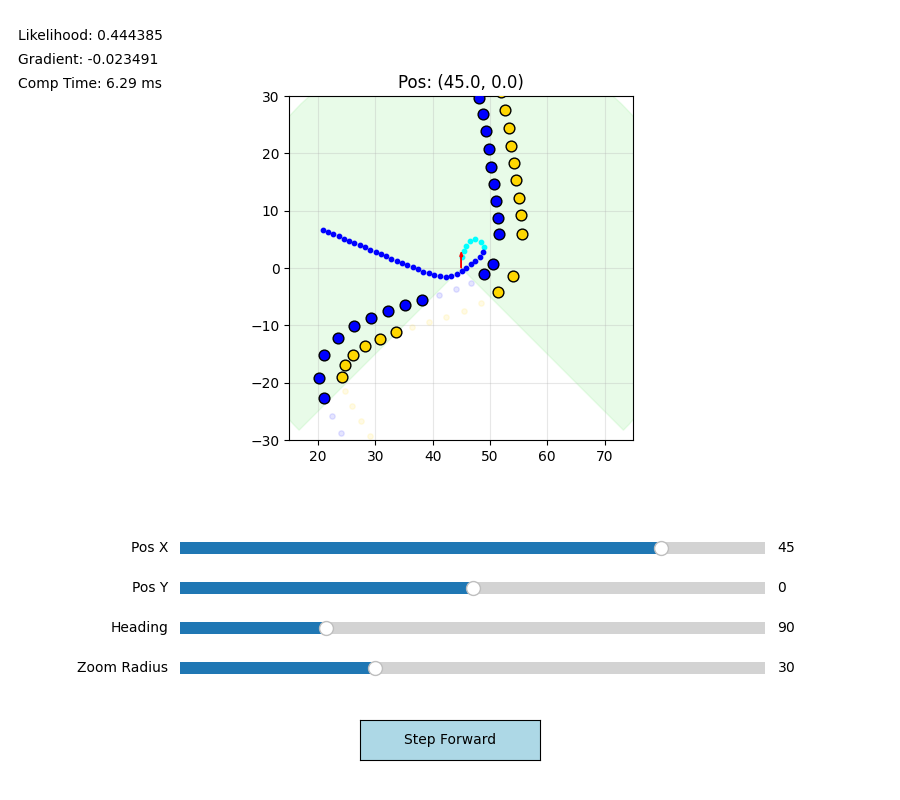

In [3]:

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button # <--- Import Button
from matplotlib.patches import Wedge
import numpy as np
import pandas as pd
import time
import math
from Path_planer import PathPlanner
from Yaw_optimizer import YawOptimizer
import object as obj

# --- 1. MOCK DATA & FUNCTIONS (To ensure standalone runnability) ---
try:
    from Path_planer import generate_path
except ImportError:
    # Fallback if file is missing
    def generate_path(start_pos, start_yaw, cones, num_step=20, step_size=2.0, lr=0.1, optimize_steps=10):
        timestamp = time.time()
        path = [start_pos]
        pos = start_pos
        yaw = start_yaw
        
        # Mock Mock Likelihood for path generation
        for _ in range(num_step):
            # Simple logic: turn slightly left to simulate a curve
            yaw += 0.05 
            pos = (pos[0] + math.cos(yaw) * step_size, pos[1] + math.sin(yaw) * step_size)
            path.append(pos)
        period = time.time() - timestamp
        return path, period

class MockLikelihood:
    def cal_likelihood(self, *args, **kwargs): return 0.5
    def cal_likelihood_gradient(self, *args, **kwargs): return 0.01

# Initial Setup
try:
    map_gen = map # Try using existing map
except NameError:
    class MockMap:
        def __init__(self):
            t = np.linspace(0, 4*np.pi, 200)
            self.blue_cones = np.column_stack((50*np.cos(t), 30*np.sin(t)))
            self.yellow_cones = np.column_stack((40*np.cos(t), 20*np.sin(t)))
            self.big_orange_cones = np.array([[0,0]])
        def get_cones_in_fov(self, car_pos, car_heading, fov_angle_deg, max_range):
            # Simple mock filter
            cones = []
            for c in self.blue_cones: cones.append({'x': c[0], 'y': c[1], 'color': 'blue'})
            for c in self.yellow_cones: cones.append({'x': c[0], 'y': c[1], 'color': 'yellow'})
            df = pd.DataFrame(cones)
            if df.empty: return df
            df['dist'] = np.sqrt((df['x'] - car_pos[0])**2 + (df['y'] - car_pos[1])**2)
            return df[df['dist'] <= max_range]
    map_gen = MockMap()
    likelihood = MockLikelihood()

FOV_ANGLE = 270
MAX_RANGE = 40

# Global variable to store the next calculated target
next_step_target = None

# --- 2. Layout Setup ---
fig, ax = plt.subplots(figsize=(9, 8))
plt.subplots_adjust(bottom=0.45) # Increased bottom margin for Button

# --- 3. Create UI Elements ---
ax_x = plt.axes([0.2, 0.30, 0.65, 0.03])
ax_y = plt.axes([0.2, 0.25, 0.65, 0.03])
ax_yaw = plt.axes([0.2, 0.20, 0.65, 0.03])
ax_zoom = plt.axes([0.2, 0.15, 0.65, 0.03])

# Button Axis
ax_button = plt.axes([0.4, 0.05, 0.2, 0.05]) # [left, bottom, width, height]

s_x = Slider(ax_x, 'Pos X', -70, 70, valinit=45)
s_y = Slider(ax_y, 'Pos Y', -50, 50, valinit=0)
s_yaw = Slider(ax_yaw, 'Heading', 0, 360, valinit=90)
s_zoom = Slider(ax_zoom, 'Zoom Radius', 5, 80, valinit=30)
btn_step = Button(ax_button, 'Step Forward', color='lightblue', hovercolor='0.975')

# Info Text
prob_text = plt.figtext(0.02, 0.95, "Likelihood: NaN", fontsize=10)
gradient_text = plt.figtext(0.02, 0.92, "Gradient: NaN", fontsize=10)
time_text = plt.figtext(0.02, 0.89, "Time: NaN", fontsize=10)

path_planner = PathPlanner()


# --- 4. The Update Function ---
def update(val):
    global next_step_target
    
    curr_x = s_x.val
    curr_y = s_y.val
    yaw_deg = s_yaw.val
    zoom_dist = s_zoom.val
    yaw_rad = np.radians(yaw_deg)
    
    # Get Sensor Data
    visible_df = map_gen.get_cones_in_fov(
        car_pos=(curr_x, curr_y), 
        car_heading=yaw_rad, 
        fov_angle_deg=FOV_ANGLE, 
        max_range=MAX_RANGE
    )

    # --- DRAWING ---
    ax.clear()
    
    # 1. Draw Ghost Map
    b = np.array(map_gen.blue_cones)
    y = np.array(map_gen.yellow_cones)
    if len(b) > 0: ax.scatter(b[:,0], b[:,1], c='blue', s=15, alpha=0.1)
    if len(y) > 0: ax.scatter(y[:,0], y[:,1], c='gold', s=15, alpha=0.1)

    # 2. Draw FOV
    fov_patch = Wedge(
        (curr_x, curr_y), MAX_RANGE, yaw_deg - FOV_ANGLE/2, yaw_deg + FOV_ANGLE/2,  
        color='lightgreen', alpha=0.2
    )
    ax.add_patch(fov_patch)

    # 3. Draw Visible Cones
    if not visible_df.empty:
        vis_b = visible_df[visible_df['color'] == 'blue']
        vis_y = visible_df[visible_df['color'] == 'yellow']
        if not vis_b.empty: ax.scatter(vis_b['x'], vis_b['y'], c='blue', s=60, edgecolors='k', zorder=5)
        if not vis_y.empty: ax.scatter(vis_y['x'], vis_y['y'], c='gold', s=60, edgecolors='k', zorder=5)

    # 4. Draw Car Vector
    ax.arrow(curr_x, curr_y, np.cos(yaw_rad)*2, np.sin(yaw_rad)*2, 
             head_width=0.5, color='red', zorder=6)

    # 5. Dynamic Limits
    ax.set_xlim(curr_x - zoom_dist, curr_x + zoom_dist)
    ax.set_ylim(curr_y - zoom_dist, curr_y + zoom_dist)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Pos: ({curr_x:.1f}, {curr_y:.1f})")

    # --- PATH GENERATION ---
    sim_path, sim_probs, period = path_planner.generate_path(
        start_pos=(curr_x, curr_y),
        start_yaw=yaw_rad,
        cones=[obj.Cone(x=row['x'], y=row['y'], color=row['color']) for _, row in visible_df.iterrows()],
    )
    time_text.set_text(f"Comp Time: {period*1000:.2f} ms")

    sim_path.pop(0) # Remove starting point to avoid overlap
    
    path_x = [p[0] for i, p in enumerate(sim_path) if sim_probs[i] > 0.005]
    path_y = [p[1] for i, p in enumerate(sim_path) if sim_probs[i] > 0.005]
    ax.scatter(path_x, path_y, c='cyan', s=10, zorder=4)

    path_x_low_conf = [p[0] for i, p in enumerate(sim_path) if sim_probs[i] <= 0.005]
    path_y_low_conf = [p[1] for i, p in enumerate(sim_path) if sim_probs[i] <= 0.005]
    ax.scatter(path_x_low_conf, path_y_low_conf, c='blue', s=10, zorder=4)

    # --- STORE NEXT STEP FOR BUTTON ---
    if len(sim_path) > 1:
        next_step_target = sim_path[1] # The point immediately after current position
    else:
        next_step_target = None

    # --- Likelihood Stats ---
        # Only run if likelihood module is available
    yawOptimizer = YawOptimizer()
    yawOptimizer.load_data(
        car_pos=(curr_x, curr_y),
        car_yaw=yaw_rad,
        cones=[obj.Cone(x=row['x'], y=row['y'], color=row['color']) for _, row in visible_df.iterrows()]
    )
    prob = yawOptimizer.cal_prob()
    prob_text.set_text(f"Likelihood: {prob:.6f}")
    
    grad = yawOptimizer.cal_gradient()
    gradient_text.set_text(f"Gradient: {grad:.6f}")

# --- 5. Button Logic ---
def step_forward(event):
    global next_step_target
    
    if next_step_target is None:
        print("No path generated, cannot step forward.")
        return

    # 1. Calculate new Position
    new_x, new_y = next_step_target
    
    # 2. Calculate new Heading (Orientation towards the new point)
    dx = new_x - s_x.val
    dy = new_y - s_y.val
    new_yaw_rad = np.arctan2(dy, dx)
    new_yaw_deg = np.degrees(new_yaw_rad)
    
    # Normalize to 0-360 for the slider
    if new_yaw_deg < 0: new_yaw_deg += 360
    
    # 3. Update Sliders (This automatically triggers update())
    s_x.set_val(new_x)
    s_y.set_val(new_y)
    s_yaw.set_val(new_yaw_deg)

# Attach Callbacks
s_x.on_changed(update)
s_y.on_changed(update)
s_yaw.on_changed(update)
s_zoom.on_changed(update)
btn_step.on_clicked(step_forward) # <--- Attach Button

# Initial Draw
update(0)
plt.show()